In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 1: IMPORTS & CONFIGURATION                                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("=" * 90)
print("CELL 1: IMPORTS & CONFIGURATION")
print("=" * 90)

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from collections import defaultdict, Counter
import json
import time
import random
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

DATASET_ROOT = "/content/drive/MyDrive/Dataset"
SAVE_DIR = "/content/drive/MyDrive/Pakistan_Models_v6_Variable"
V4_MODEL_PATH = "/content/drive/MyDrive/Pakistan_Models_v4/best_model_v4.pth"
CHECKPOINT_PATH = None  # Set to resume V6 training

# Training config - Fine-tuning settings
NUM_EPOCHS = 20  # Fewer epochs for fine-tuning
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
NUM_WORKERS = 2

# Temporal config
NUM_BANDS = 4
NUM_MONTHS = 6
NUM_CHANNELS = NUM_MONTHS * NUM_BANDS  # 24

# Classes
CLASS_NAMES = ['Other', 'Rice', 'Wheat']
NUM_CLASSES = 3
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for idx, name in enumerate(CLASS_NAMES)}

# Month indices
MONTH_NAMES = ['May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov']
MONTH_TO_IDX = {name: idx for idx, name in enumerate(MONTH_NAMES)}

# Months per class
MONTHS_BY_CLASS = {
    'Rice': ['May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov'],
    'Wheat': ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
    'Other_Rice': ['May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov'],
    'Other_Wheat': ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
}

# Fine-tuning hyperparameters
LABEL_SMOOTHING = 0.1
DROPOUT_RATE = 0.4
WEIGHT_DECAY = 0.03

print(f"\n✓ Configuration loaded (V6 Variable Input)")
print(f"  Base Model: V4 from {V4_MODEL_PATH}")
print(f"  Save dir: {SAVE_DIR}")
print(f"  Fine-tuning epochs: {NUM_EPOCHS}")
print(f"  Strategy: Curriculum masking (gradual difficulty)")


CELL 1: IMPORTS & CONFIGURATION

✓ Configuration loaded (V6 Variable Input)
  Base Model: V4 from /content/drive/MyDrive/Pakistan_Models_v4/best_model_v4.pth
  Save dir: /content/drive/MyDrive/Pakistan_Models_v6_Variable
  Fine-tuning epochs: 20
  Strategy: Curriculum masking (gradual difficulty)


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 2: MOUNT DRIVE & DEPENDENCIES                                       ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 2: MOUNT DRIVE & DEPENDENCIES")
print("=" * 90)

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

try:
    import rasterio
    print("\n✓ rasterio ready")
except ImportError:
    os.system("pip install -q rasterio")
    import rasterio
    print("✓ rasterio installed")

try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("✓ sklearn ready")
except ImportError:
    os.system("pip install -q scikit-learn")
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("✓ sklearn installed")

import torchvision.models as models

assert os.path.exists(DATASET_ROOT), f"Dataset not found: {DATASET_ROOT}"
assert os.path.exists(V4_MODEL_PATH), f"V4 model not found: {V4_MODEL_PATH}"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n✓ Dataset found: {DATASET_ROOT}")
print(f"✓ V4 model found: {V4_MODEL_PATH}")
print(f"✓ Save directory: {SAVE_DIR}")



CELL 2: MOUNT DRIVE & DEPENDENCIES
Mounted at /content/drive

✓ rasterio ready
✓ sklearn ready

✓ Dataset found: /content/drive/MyDrive/Dataset
✓ V4 model found: /content/drive/MyDrive/Pakistan_Models_v4/best_model_v4.pth
✓ Save directory: /content/drive/MyDrive/Pakistan_Models_v6_Variable


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 3: COLLECT AND ORGANIZE FILES                                       ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 3: COLLECT AND ORGANIZE FILES")
print("=" * 90)

def get_months_for_sample(class_name, location_id):
    if class_name == 'Rice':
        return MONTHS_BY_CLASS['Rice']
    elif class_name == 'Wheat':
        return MONTHS_BY_CLASS['Wheat']
    elif class_name == 'Other':
        try:
            id_num = int(location_id)
            if id_num <= 50:
                return MONTHS_BY_CLASS['Other_Wheat']
            else:
                return MONTHS_BY_CLASS['Other_Rice']
        except:
            return MONTHS_BY_CLASS['Other_Rice']
    return MONTHS_BY_CLASS['Rice']

def parse_filename(filename):
    name = filename.replace('.tif', '').replace('.TIF', '')
    parts = name.split('_')
    if len(parts) >= 3:
        cls = parts[0].capitalize()
        loc_id = parts[1]
        month = parts[-1].capitalize()
        return cls, loc_id, month
    return None, None, None

# Collect samples
all_samples = defaultdict(lambda: {'class': None, 'files': {}, 'year': None, 'loc_id': None})

print("\nScanning dataset...")
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATASET_ROOT, class_name)
    if not os.path.exists(class_path):
        continue

    for year in ['2023', '2024']:
        year_path = os.path.join(class_path, year)
        if not os.path.exists(year_path):
            continue

        files = [f for f in os.listdir(year_path) if f.lower().endswith('.tif')]
        for f in files:
            cls, loc_id, month = parse_filename(f)
            if cls is None:
                continue

            sample_key = f"{class_name}_{year}_{loc_id}"
            all_samples[sample_key]['class'] = class_name
            all_samples[sample_key]['year'] = year
            all_samples[sample_key]['loc_id'] = loc_id
            all_samples[sample_key]['files'][month] = os.path.join(year_path, f)

print(f"\n✓ Total samples: {len(all_samples)}")

class_counts = Counter([s['class'] for s in all_samples.values()])
print(f"\nBy class:")
for cls, count in sorted(class_counts.items()):
    print(f"  {cls}: {count}")



CELL 3: COLLECT AND ORGANIZE FILES

Scanning dataset...

✓ Total samples: 616

By class:
  Other: 200
  Rice: 216
  Wheat: 200


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 4: FILTER & CREATE SPLITS                                           ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 4: FILTER & CREATE SPLITS")
print("=" * 90)

MIN_MONTHS = 5

filtered_samples = {k: v for k, v in all_samples.items() if len(v['files']) >= MIN_MONTHS}
print(f"\n✓ Samples with {MIN_MONTHS}+ months: {len(filtered_samples)}")

class_counts_filtered = Counter([s['class'] for s in filtered_samples.values()])
print(f"\nBy class (filtered):")
for cls, count in sorted(class_counts_filtered.items()):
    print(f"  {cls}: {count}")

# Stratified split (same as V4 for fair comparison)
samples_by_class = defaultdict(list)
for key, data in filtered_samples.items():
    samples_by_class[data['class']].append(key)

train_keys, val_keys, test_keys = [], [], []

print(f"\nCreating 70/15/15 splits...")
for cls, keys in samples_by_class.items():
    train_k, temp_k = train_test_split(keys, test_size=0.3, random_state=42)
    val_k, test_k = train_test_split(temp_k, test_size=0.5, random_state=42)

    train_keys.extend(train_k)
    val_keys.extend(val_k)
    test_keys.extend(test_k)

    print(f"  {cls}: train={len(train_k)}, val={len(val_k)}, test={len(test_k)}")

print(f"\n✓ Total: train={len(train_keys)}, val={len(val_keys)}, test={len(test_keys)}")



CELL 4: FILTER & CREATE SPLITS

✓ Samples with 5+ months: 616

By class (filtered):
  Other: 200
  Rice: 216
  Wheat: 200

Creating 70/15/15 splits...
  Other: train=140, val=30, test=30
  Rice: train=151, val=32, test=33
  Wheat: train=140, val=30, test=30

✓ Total: train=431, val=92, test=93


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 5: DATASET WITH VARIABLE MASKING                                    ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 5: DATASET WITH VARIABLE MASKING")
print("=" * 90)

class VariableMaskingDataset(Dataset):
    """
    Dataset that randomly masks months during training.
    Model learns to classify with ANY number of available months.
    """

    def __init__(self, sample_keys, all_samples, augment=False,
                 min_months_keep=1, max_months_mask=5, mask_prob=0.7):
        """
        Args:
            min_months_keep: Minimum months to keep (at least 1)
            max_months_mask: Maximum months to mask (0-5)
            mask_prob: Probability of applying masking (0.7 = 70% of samples masked)
        """
        self.sample_keys = sample_keys
        self.all_samples = all_samples
        self.augment = augment
        self.min_months_keep = min_months_keep
        self.max_months_mask = max_months_mask
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.sample_keys)

    def set_masking_params(self, min_keep, max_mask, prob):
        """Update masking parameters (for curriculum learning)"""
        self.min_months_keep = min_keep
        self.max_months_mask = max_mask
        self.mask_prob = prob

    def load_image(self, sample_key):
        sample = self.all_samples[sample_key]
        class_name = sample['class']
        loc_id = sample['loc_id']
        months_order = get_months_for_sample(class_name, loc_id)

        image = np.zeros((NUM_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]), dtype=np.float32)

        for month_idx, month in enumerate(months_order):
            if month not in sample['files']:
                continue

            filepath = sample['files'][month]
            channel_start = month_idx * NUM_BANDS

            try:
                with rasterio.open(filepath) as src:
                    data = src.read()
                    data = np.nan_to_num(data, nan=0, posinf=10000, neginf=0)
                    data = data.astype(np.float32) / 10000.0
                    data = np.clip(data, 0, 1)

                    for b in range(min(data.shape[0], NUM_BANDS)):
                        band = Image.fromarray((data[b] * 255).astype(np.uint8))
                        band = band.resize(IMAGE_SIZE, Image.BILINEAR)
                        image[channel_start + b] = np.array(band).astype(np.float32) / 255.0
            except:
                pass

        return image

    def apply_masking(self, image):
        """
        Randomly mask some months by setting their channels to zero.
        Returns masked image and availability mask.
        """
        # Decide whether to apply masking
        if random.random() > self.mask_prob:
            # No masking - return full image
            availability = np.ones(NUM_MONTHS, dtype=np.float32)
            return image, availability

        # Decide how many months to mask (0 to max_months_mask)
        num_to_mask = random.randint(0, self.max_months_mask)

        # Ensure we keep at least min_months_keep
        num_to_mask = min(num_to_mask, NUM_MONTHS - self.min_months_keep)

        if num_to_mask == 0:
            availability = np.ones(NUM_MONTHS, dtype=np.float32)
            return image, availability

        # Randomly select which months to mask
        months_to_mask = random.sample(range(NUM_MONTHS), num_to_mask)

        # Create masked image
        masked_image = image.copy()
        availability = np.ones(NUM_MONTHS, dtype=np.float32)

        for month_idx in months_to_mask:
            start_ch = month_idx * NUM_BANDS
            end_ch = start_ch + NUM_BANDS
            masked_image[start_ch:end_ch, :, :] = 0  # Set to zero
            availability[month_idx] = 0  # Mark as unavailable

        return masked_image, availability

    def apply_augmentation(self, image, class_name):
        # Basic augmentations
        if np.random.random() > 0.5:
            image = image[:, :, ::-1].copy()

        if np.random.random() > 0.5:
            image = image[:, ::-1, :].copy()

        k = np.random.randint(0, 4)
        if k > 0:
            image = np.rot90(image, k, axes=(1, 2)).copy()

        # Brightness
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.85, 1.15)
            image = np.clip(image * factor, 0, 1)

        # Contrast
        if np.random.random() > 0.5:
            mean = image.mean()
            factor = np.random.uniform(0.85, 1.15)
            image = np.clip((image - mean) * factor + mean, 0, 1)

        # Noise
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape).astype(np.float32)
            image = np.clip(image + noise, 0, 1)

        return image.astype(np.float32)

    def __getitem__(self, idx):
        sample_key = self.sample_keys[idx]
        sample = self.all_samples[sample_key]

        label = CLASS_TO_IDX[sample['class']]
        image = self.load_image(sample_key)

        if self.augment:
            image = self.apply_augmentation(image, sample['class'])

        # Apply random masking
        if self.augment:  # Only mask during training
            image, availability = self.apply_masking(image)
        else:
            availability = np.ones(NUM_MONTHS, dtype=np.float32)

        return (torch.from_numpy(image),
                torch.from_numpy(availability),
                label)

print("✓ VariableMaskingDataset defined")
print(f"  - Randomly masks 0-5 months during training")
print(f"  - Always keeps at least 1 month")
print(f"  - Returns availability mask for model awareness")



CELL 5: DATASET WITH VARIABLE MASKING
✓ VariableMaskingDataset defined
  - Randomly masks 0-5 months during training
  - Always keeps at least 1 month
  - Returns availability mask for model awareness


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 6: CREATE DATALOADERS                                               ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 6: CREATE DATALOADERS")
print("=" * 90)

from torch.utils.data import WeightedRandomSampler

# Initial masking params (will be updated via curriculum)
train_dataset = VariableMaskingDataset(
    train_keys, filtered_samples, augment=True,
    min_months_keep=4, max_months_mask=2, mask_prob=0.5  # Start easy
)
val_dataset = VariableMaskingDataset(
    val_keys, filtered_samples, augment=False,
    min_months_keep=1, max_months_mask=0, mask_prob=0.0  # No masking for val
)
test_dataset = VariableMaskingDataset(
    test_keys, filtered_samples, augment=False,
    min_months_keep=1, max_months_mask=0, mask_prob=0.0  # No masking for test
)

print(f"\n  Train: {len(train_dataset)} (with masking)")
print(f"  Val: {len(val_dataset)} (no masking)")
print(f"  Test: {len(test_dataset)} (no masking)")

# Class distribution
train_labels = [filtered_samples[k]['class'] for k in train_keys]
train_class_counts = Counter(train_labels)

print(f"\nTraining distribution:")
for cls, count in sorted(train_class_counts.items()):
    print(f"  {cls}: {count}")

# Weighted sampler
class_weights_sampler = {}
for cls, count in train_class_counts.items():
    weight = 1.0 / count
    if cls == 'Wheat':
        weight *= 1.2
    class_weights_sampler[cls] = weight

sample_weights = [class_weights_sampler[filtered_samples[k]['class']] for k in train_keys]
sample_weights = torch.DoubleTensor(sample_weights)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)

print(f"\n✓ Weighted sampler created")

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

print(f"\n  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")



CELL 6: CREATE DATALOADERS

  Train: 431 (with masking)
  Val: 92 (no masking)
  Test: 93 (no masking)

Training distribution:
  Other: 140
  Rice: 151
  Wheat: 140

✓ Weighted sampler created

  Train batches: 13
  Val batches: 3
  Test batches: 3


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 7: MODEL WITH AVAILABILITY AWARENESS                                ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 7: MODEL DEFINITION")
print("=" * 90)

class VariableInputResNet34(nn.Module):
    """
    ResNet34 with availability mask awareness.
    Can classify crops with ANY number of available months (1-6).
    """

    def __init__(self, num_classes=3, in_channels=24, dropout_rate=0.4):
        super().__init__()

        # Base ResNet34
        self.base = models.resnet34(weights=None)

        # Modify first conv for 24 channels
        self.base.conv1 = nn.Conv2d(
            in_channels, 64,
            kernel_size=7, stride=2, padding=3, bias=False
        )

        # Get backbone output features
        num_backbone_features = self.base.fc.in_features  # 512

        # Availability embedding (tells model which months are real)
        self.availability_embed = nn.Sequential(
            nn.Linear(NUM_MONTHS, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True)
        )

        # Replace FC with combined classifier
        self.base.fc = nn.Identity()  # Remove original FC

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_backbone_features + 64, 512),  # 512 + 64 = 576
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate / 2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, availability_mask):
        # Extract image features through backbone
        img_features = self.base(x)  # [batch, 512]

        # Embed availability information
        avail_features = self.availability_embed(availability_mask)  # [batch, 64]

        # Combine and classify
        combined = torch.cat([img_features, avail_features], dim=1)  # [batch, 576]
        output = self.classifier(combined)

        return output

print("✓ VariableInputResNet34 defined")
print("  - Accepts 24-channel image + 6-element availability mask")
print("  - Availability mask tells model which months are real data")



CELL 7: MODEL DEFINITION
✓ VariableInputResNet34 defined
  - Accepts 24-channel image + 6-element availability mask
  - Availability mask tells model which months are real data


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 8: LOAD V4 WEIGHTS & SETUP TRAINING                                 ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 8: LOAD V4 & SETUP TRAINING")
print("=" * 90)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create new model
model = VariableInputResNet34(
    num_classes=NUM_CLASSES,
    in_channels=NUM_CHANNELS,
    dropout_rate=DROPOUT_RATE
)

# Load V4 weights (partial - backbone only)
print(f"\nLoading V4 weights from: {V4_MODEL_PATH}")
v4_checkpoint = torch.load(V4_MODEL_PATH, map_location=device)
v4_state_dict = v4_checkpoint['model_state_dict']

# Map V4 weights to new model
new_state_dict = model.state_dict()
loaded_keys = []
skipped_keys = []

for key, value in v4_state_dict.items():
    if key in new_state_dict:
        if new_state_dict[key].shape == value.shape:
            new_state_dict[key] = value
            loaded_keys.append(key)
        else:
            skipped_keys.append(f"{key} (shape mismatch)")
    elif key.startswith('base.'):
        # Try direct mapping
        if key in new_state_dict and new_state_dict[key].shape == value.shape:
            new_state_dict[key] = value
            loaded_keys.append(key)
        else:
            skipped_keys.append(key)
    else:
        skipped_keys.append(key)

model.load_state_dict(new_state_dict)
model = model.to(device)

print(f"\n✓ Loaded {len(loaded_keys)} weight tensors from V4")
print(f"  Skipped {len(skipped_keys)} tensors (new layers)")

if len(skipped_keys) > 0 and len(skipped_keys) <= 20:
    print(f"\n  New/modified layers (randomly initialized):")
    for key in skipped_keys[:10]:
        print(f"    - {key}")
    if len(skipped_keys) > 10:
        print(f"    ... and {len(skipped_keys) - 10} more")

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Total parameters: {total_params:,}")

# ─────────────────────────────────────────────────────────────────────────────
# LOSS FUNCTION
# ─────────────────────────────────────────────────────────────────────────────

class FocalLossWithSmoothing(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)

        with torch.no_grad():
            smooth_targets = torch.zeros_like(inputs)
            smooth_targets.fill_(self.smoothing / (num_classes - 1))
            smooth_targets.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)

        log_probs = F.log_softmax(inputs, dim=-1)

        if self.alpha is not None:
            alpha_weight = self.alpha[targets]
            loss = -alpha_weight.unsqueeze(1) * smooth_targets * log_probs
        else:
            loss = -smooth_targets * log_probs

        loss = loss.sum(dim=-1)

        probs = torch.exp(log_probs)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - pt) ** self.gamma
        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()

# Class weights
class_counts_array = np.array([
    train_class_counts.get('Other', 1),
    train_class_counts.get('Rice', 1),
    train_class_counts.get('Wheat', 1)
], dtype=np.float32)

class_weights = 1.0 / class_counts_array
class_weights[2] *= 1.3  # Boost Wheat
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"\nClass weights:")
for i, cls in enumerate(CLASS_NAMES):
    print(f"  {cls}: {class_weights[i]:.4f}")

criterion = FocalLossWithSmoothing(
    alpha=class_weights,
    gamma=2.0,
    smoothing=LABEL_SMOOTHING
)

# ─────────────────────────────────────────────────────────────────────────────
# OPTIMIZER - Different LR for pretrained vs new layers
# ─────────────────────────────────────────────────────────────────────────────

pretrained_params = []
new_params = []

for name, param in model.named_parameters():
    if 'availability_embed' in name or 'classifier' in name:
        new_params.append(param)
    else:
        pretrained_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': pretrained_params, 'lr': 1e-5},   # Very low LR for pretrained
    {'params': new_params, 'lr': 5e-4}           # Higher LR for new layers
], weight_decay=WEIGHT_DECAY)

print(f"\nOptimizer setup:")
print(f"  Pretrained layers: lr=1e-5 ({len(pretrained_params)} tensors)")
print(f"  New layers: lr=5e-4 ({len(new_params)} tensors)")

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
)

# Mixed precision
use_amp = device.type == "cuda"
scaler = torch.amp.GradScaler('cuda') if use_amp else None

print(f"\n✓ Training setup complete")
print(f"  Loss: Focal Loss + Label Smoothing")
print(f"  AMP: {use_amp}")

# Tracking
start_epoch = 0
best_val_f1 = 0.0
best_val_acc = 0.0
patience_counter = 0
PATIENCE = 10

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'lr': [], 'masking_params': []
}



CELL 8: LOAD V4 & SETUP TRAINING

Device: cuda
GPU: Tesla T4

Loading V4 weights from: /content/drive/MyDrive/Pakistan_Models_v4/best_model_v4.pth

✓ Loaded 216 weight tensors from V4
  Skipped 16 tensors (new layers)

  New/modified layers (randomly initialized):
    - base.fc.1.weight
    - base.fc.1.bias
    - base.fc.2.weight
    - base.fc.2.bias
    - base.fc.2.running_mean
    - base.fc.2.running_var
    - base.fc.2.num_batches_tracked
    - base.fc.5.weight
    - base.fc.5.bias
    - base.fc.6.weight
    ... and 6 more

✓ Total parameters: 21,715,619

Class weights:
  Other: 0.9296
  Rice: 0.8619
  Wheat: 1.2085

Optimizer setup:
  Pretrained layers: lr=1e-5 (108 tensors)
  New layers: lr=5e-4 (14 tensors)

✓ Training setup complete
  Loss: Focal Loss + Label Smoothing
  AMP: True


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 9: CURRICULUM TRAINING WITH PROGRESSIVE MASKING                     ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 9: CURRICULUM TRAINING")
print("=" * 90)

def get_curriculum_params(epoch, total_epochs):
    """
    Progressive masking curriculum:
    - Early epochs: Easy (mask 0-2 months, keep 4-6)
    - Middle epochs: Medium (mask 0-3 months, keep 3-6)
    - Late epochs: Hard (mask 0-5 months, keep 1-6)
    """
    progress = epoch / total_epochs

    if progress < 0.3:
        # Phase 1: Easy
        return {'min_keep': 4, 'max_mask': 2, 'prob': 0.5}
    elif progress < 0.6:
        # Phase 2: Medium
        return {'min_keep': 3, 'max_mask': 3, 'prob': 0.6}
    else:
        # Phase 3: Hard
        return {'min_keep': 1, 'max_mask': 5, 'prob': 0.7}

print(f"\nCurriculum Schedule:")
print(f"  Epochs 1-6:   Easy   (keep 4-6 months, mask 0-2)")
print(f"  Epochs 7-12:  Medium (keep 3-6 months, mask 0-3)")
print(f"  Epochs 13-20: Hard   (keep 1-6 months, mask 0-5)")

print(f"\nStarting fine-tuning from epoch {start_epoch + 1}")

start_time = time.time()

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start = time.time()

    # Update curriculum
    curriculum = get_curriculum_params(epoch, NUM_EPOCHS)
    train_dataset.set_masking_params(
        curriculum['min_keep'],
        curriculum['max_mask'],
        curriculum['prob']
    )

    current_lr = optimizer.param_groups[0]['lr']

    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")
    print(f"Masking: keep {curriculum['min_keep']}-6 months, prob={curriculum['prob']}")
    print(f"{'='*70}")

    # ─────────────────────────────────────────────────────────────────────────
    # TRAINING
    # ─────────────────────────────────────────────────────────────────────────
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, availability, labels in pbar:
        images = images.to(device)
        availability = availability.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        if use_amp:
            with torch.amp.autocast('cuda'):
                outputs = model(images, availability)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images, availability)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*train_correct/train_total:.1f}%")

    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total

    scheduler.step()

    # ─────────────────────────────────────────────────────────────────────────
    # VALIDATION (no masking)
    # ─────────────────────────────────────────────────────────────────────────
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels_list = [], []

    with torch.no_grad():
        for images, availability, labels in tqdm(val_loader, desc="Val", leave=False):
            images = images.to(device)
            availability = availability.to(device)
            labels = labels.to(device)

            if use_amp:
                with torch.amp.autocast('cuda'):
                    outputs = model(images, availability)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images, availability)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_preds, average='macro')

    epoch_time = (time.time() - epoch_start) / 60

    print(f"\n  Train: loss={train_loss:.4f}, acc={train_acc:.2f}%")
    print(f"  Val:   loss={val_loss:.4f}, acc={val_acc:.2f}%, F1={val_f1:.4f}")
    print(f"  Time:  {epoch_time:.1f} min")

    # Per-class recall
    val_cm = confusion_matrix(val_labels_list, val_preds)
    print(f"  Per-class recall: ", end="")
    for i, name in enumerate(CLASS_NAMES):
        if val_cm[i].sum() > 0:
            recall = val_cm[i, i] / val_cm[i].sum()
            print(f"{name}={recall:.1%} ", end="")
    print()

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    history['masking_params'].append(curriculum)

    # Save best
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        patience_counter = 0

        best_path = os.path.join(SAVE_DIR, "best_model_v6_variable.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1,
            'class_names': CLASS_NAMES,
            'num_channels': NUM_CHANNELS,
            'model_type': 'VariableInputResNet34',
        }, best_path)
        print(f"  ✓ NEW BEST! F1={val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{PATIENCE}")

    # Checkpoint
    if (epoch + 1) % 5 == 0:
        ckpt_path = os.path.join(SAVE_DIR, f"checkpoint_v6_ep{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'best_val_f1': best_val_f1,
        }, ckpt_path)
        print(f"  ✓ Checkpoint saved")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

total_time = (time.time() - start_time) / 60
print(f"\n{'='*70}")
print(f"✓ FINE-TUNING COMPLETE")
print(f"  Best F1: {best_val_f1:.4f}")
print(f"  Best Acc: {best_val_acc:.2f}%")
print(f"  Total time: {total_time:.1f} min")
print(f"{'='*70}")



CELL 9: CURRICULUM TRAINING

Curriculum Schedule:
  Epochs 1-6:   Easy   (keep 4-6 months, mask 0-2)
  Epochs 7-12:  Medium (keep 3-6 months, mask 0-3)
  Epochs 13-20: Hard   (keep 1-6 months, mask 0-5)

Starting fine-tuning from epoch 1

Epoch 1/20 | LR: 1.00e-05
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.2603, acc=74.52%
  Val:   loss=0.1145, acc=88.04%, F1=0.8775
  Time:  2.3 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=76.7% 
  ✓ NEW BEST! F1=0.8775

Epoch 2/20 | LR: 9.94e-06
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.1309, acc=84.38%
  Val:   loss=0.0933, acc=90.22%, F1=0.8997
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=80.0% 
  ✓ NEW BEST! F1=0.8997

Epoch 3/20 | LR: 9.78e-06
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.1147, acc=84.38%
  Val:   loss=0.0827, acc=85.87%, F1=0.8555
  Time:  1.0 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=76.7% 
  No improvement. Patience: 1/10

Epoch 4/20 | LR: 9.51e-06
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.0852, acc=89.42%
  Val:   loss=0.0804, acc=89.13%, F1=0.8884
  Time:  0.9 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=90.0% 
  No improvement. Patience: 2/10

Epoch 5/20 | LR: 9.14e-06
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.0824, acc=88.94%
  Val:   loss=0.0836, acc=88.04%, F1=0.8775
  Time:  0.9 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=86.7% 
  No improvement. Patience: 3/10
  ✓ Checkpoint saved

Epoch 6/20 | LR: 8.68e-06
Masking: keep 4-6 months, prob=0.5



  Train: loss=0.1100, acc=89.42%
  Val:   loss=0.0952, acc=88.04%, F1=0.8777
  Time:  1.0 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=80.0% 
  No improvement. Patience: 4/10

Epoch 7/20 | LR: 8.15e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.1410, acc=84.62%
  Val:   loss=0.0975, acc=86.96%, F1=0.8667
  Time:  0.9 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=80.0% 
  No improvement. Patience: 5/10

Epoch 8/20 | LR: 7.54e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.1308, acc=85.82%
  Val:   loss=0.0790, acc=88.04%, F1=0.8777
  Time:  0.9 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=83.3% 
  No improvement. Patience: 6/10

Epoch 9/20 | LR: 6.89e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.1032, acc=86.06%
  Val:   loss=0.0727, acc=90.22%, F1=0.8986
  Time:  0.9 min
  Per-class recall: Other=73.3% Rice=100.0% Wheat=96.7% 
  No improvement. Patience: 7/10

Epoch 10/20 | LR: 6.20e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.0981, acc=87.02%
  Val:   loss=0.0737, acc=90.22%, F1=0.8986
  Time:  0.9 min
  Per-class recall: Other=73.3% Rice=100.0% Wheat=96.7% 
  No improvement. Patience: 8/10
  ✓ Checkpoint saved

Epoch 11/20 | LR: 5.50e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.1067, acc=86.30%
  Val:   loss=0.0715, acc=90.22%, F1=0.8993
  Time:  1.0 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=93.3% 
  No improvement. Patience: 9/10

Epoch 12/20 | LR: 4.80e-06
Masking: keep 3-6 months, prob=0.6



  Train: loss=0.1134, acc=88.70%
  Val:   loss=0.0713, acc=89.13%, F1=0.8888
  Time:  0.9 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=86.7% 
  No improvement. Patience: 10/10

⚠️ Early stopping at epoch 12

✓ FINE-TUNING COMPLETE
  Best F1: 0.8997
  Best Acc: 90.22%
  Total time: 12.8 min


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 10: EVALUATION - FULL DATA (6 MONTHS)                               ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 10: EVALUATION - FULL DATA (6 MONTHS)")
print("=" * 90)

# Load best model
best_path = os.path.join(SAVE_DIR, "best_model_v6_variable.pth")
if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✓ Loaded best model (F1={checkpoint['val_f1']:.4f})")

model.eval()

test_preds_full, test_labels_full = [], []

print("\nEvaluating with FULL data (6 months)...")
with torch.no_grad():
    for images, availability, labels in tqdm(test_loader, desc="Test (6 months)"):
        images = images.to(device)
        availability = availability.to(device)  # All ones (full data)

        if use_amp:
            with torch.amp.autocast('cuda'):
                outputs = model(images, availability)
        else:
            outputs = model(images, availability)

        preds = outputs.argmax(1)
        test_preds_full.extend(preds.cpu().numpy())
        test_labels_full.extend(labels.numpy())

test_acc_full = 100 * np.mean(np.array(test_preds_full) == np.array(test_labels_full))
test_f1_full = f1_score(test_labels_full, test_preds_full, average='macro')

print(f"\n{'='*60}")
print(f"TEST RESULTS - FULL DATA (6 months)")
print(f"{'='*60}")
print(f"  Accuracy: {test_acc_full:.2f}%")
print(f"  F1 Score: {test_f1_full:.4f}")

cm_full = confusion_matrix(test_labels_full, test_preds_full)
print(f"\nConfusion Matrix:")
print(f"{'':>12}", end="")
for name in CLASS_NAMES:
    print(f"{name:>10}", end="")
print()
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:>12}", end="")
    for j in range(NUM_CLASSES):
        print(f"{cm_full[i,j]:>10}", end="")
    print()



CELL 10: EVALUATION - FULL DATA (6 MONTHS)

✓ Loaded best model (F1=0.8997)

Evaluating with FULL data (6 months)...


Test (6 months): 100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


TEST RESULTS - FULL DATA (6 months)
  Accuracy: 89.25%
  F1 Score: 0.8884

Confusion Matrix:
                 Other      Rice     Wheat
       Other        27         0         3
        Rice         0        33         0
       Wheat         7         0        23


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 11: EVALUATION - PARTIAL DATA (SIMULATED)                           ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 11: EVALUATION - PARTIAL DATA (SIMULATED)")
print("=" * 90)

def evaluate_with_n_months(model, test_loader, n_months, device, use_amp):
    """Evaluate with only n months of data (mask the rest)."""
    model.eval()
    preds, labels_list = [], []

    with torch.no_grad():
        for images, _, labels in test_loader:
            images = images.to(device)
            batch_size = images.size(0)

            # Create masked images and availability
            masked_images = images.clone()
            availability = torch.zeros(batch_size, NUM_MONTHS, device=device)

            # Keep first n months, mask the rest
            for b in range(batch_size):
                # Randomly select which n months to keep
                keep_months = random.sample(range(NUM_MONTHS), n_months)

                for month_idx in range(NUM_MONTHS):
                    if month_idx in keep_months:
                        availability[b, month_idx] = 1
                    else:
                        start_ch = month_idx * NUM_BANDS
                        end_ch = start_ch + NUM_BANDS
                        masked_images[b, start_ch:end_ch, :, :] = 0

            if use_amp:
                with torch.amp.autocast('cuda'):
                    outputs = model(masked_images, availability)
            else:
                outputs = model(masked_images, availability)

            preds.extend(outputs.argmax(1).cpu().numpy())
            labels_list.extend(labels.numpy())

    acc = 100 * np.mean(np.array(preds) == np.array(labels_list))
    f1 = f1_score(labels_list, preds, average='macro')
    return acc, f1, preds, labels_list

print("\nEvaluating with different numbers of months...")
print(f"\n{'Months':>8} {'Accuracy':>12} {'F1 Score':>12}")
print("-" * 35)

results_by_months = {}
for n in [6, 5, 4, 3, 2, 1]:
    acc, f1, preds, labels = evaluate_with_n_months(model, test_loader, n, device, use_amp)
    results_by_months[n] = {'acc': acc, 'f1': f1}
    print(f"{n:>8} {acc:>11.2f}% {f1:>12.4f}")



CELL 11: EVALUATION - PARTIAL DATA (SIMULATED)

Evaluating with different numbers of months...

  Months     Accuracy     F1 Score
-----------------------------------
       6       89.25%       0.8884
       5       84.95%       0.8419
       4       80.65%       0.7923
       3       74.19%       0.7314
       2       60.22%       0.5673
       1       37.63%       0.2333



CELL 12: SAVE RESULTS & COMPARISON
✓ History saved: /content/drive/MyDrive/Pakistan_Models_v6_Variable/history_v6_variable.json


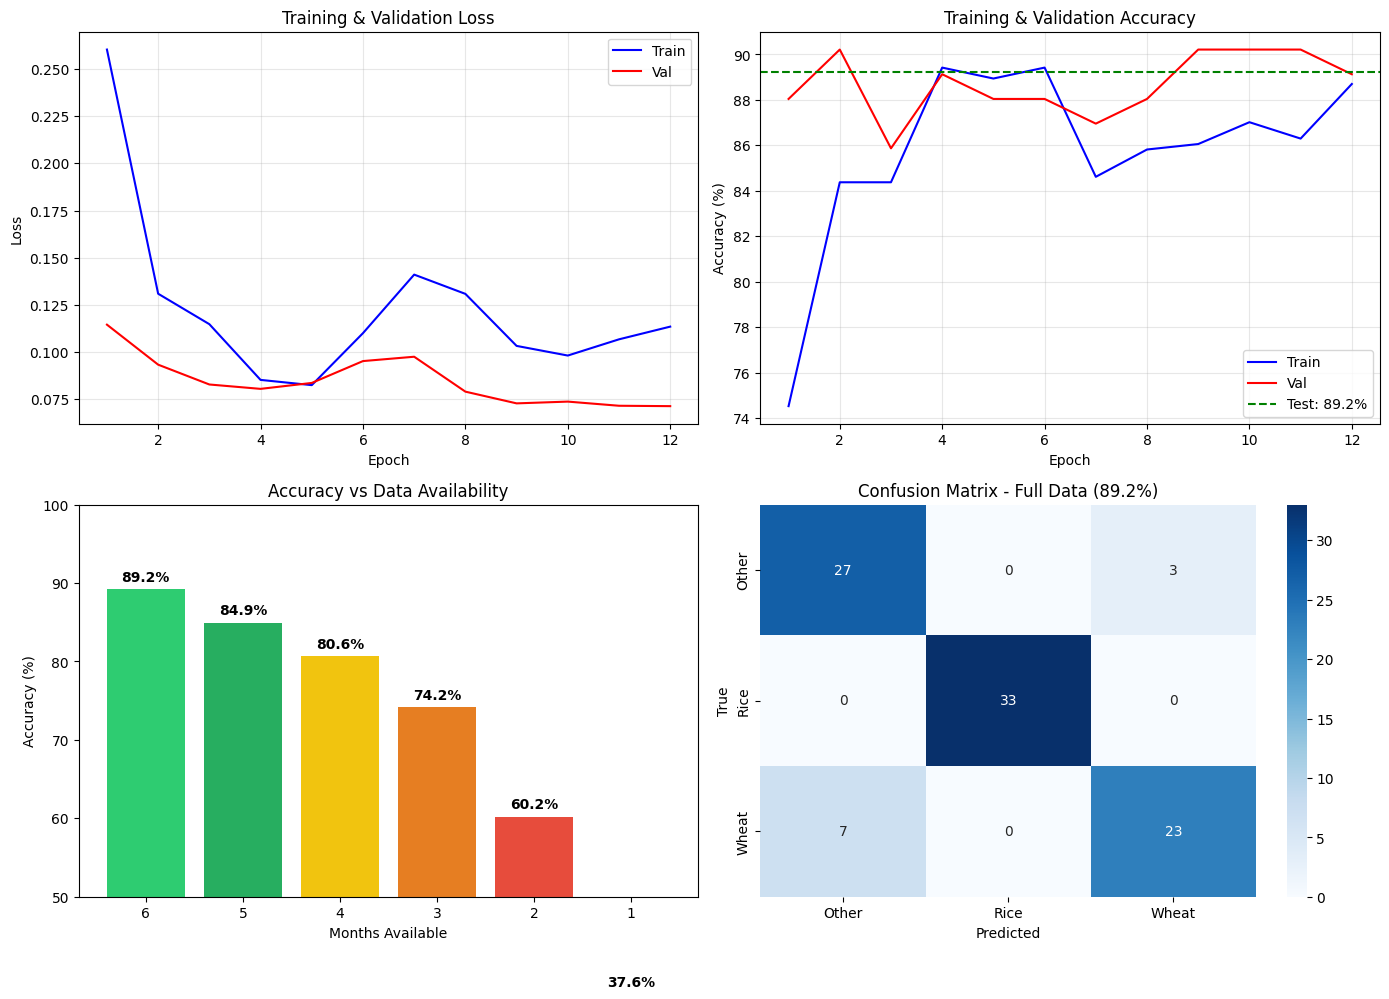

✓ Plot saved: /content/drive/MyDrive/Pakistan_Models_v6_Variable/results_v6_variable.png

V6 VARIABLE INPUT MODEL - FINAL SUMMARY

MODEL: VariableInputResNet34
  - Fine-tuned from V4 (93.55% accuracy)
  - Added availability mask awareness
  - Trained with curriculum masking

RESULTS BY DATA AVAILABILITY:

    Months     Accuracy     F1 Score          Status
----------------------------------------------------
         6       89.25%       0.8884          ✓ Good
         5       84.95%       0.8419          ✓ Good
         4       80.65%       0.7923          ✓ Good
         3       74.19%       0.7314     ⚠️ Moderate
         2       60.22%       0.5673          ⚠️ Low
         1       37.63%       0.2333          ⚠️ Low


COMPARISON WITH V4:
  V4 (6 months only): 93.55% accuracy
  V6 (6 months):      89.25% accuracy
  V6 (3 months):      74.19% accuracy
  V6 (1 month):       37.63% accuracy

FILES SAVED:
  /content/drive/MyDrive/Pakistan_Models_v6_Variable/
  ├── best_model_v6_variabl

In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 12: SAVE RESULTS & COMPARISON                                       ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 12: SAVE RESULTS & COMPARISON")
print("=" * 90)

import matplotlib.pyplot as plt
import seaborn as sns

# Save history
history_path = os.path.join(SAVE_DIR, "history_v6_variable.json")
with open(history_path, 'w') as f:
    json.dump({
        'train_loss': [float(v) for v in history['train_loss']],
        'train_acc': [float(v) for v in history['train_acc']],
        'val_loss': [float(v) for v in history['val_loss']],
        'val_acc': [float(v) for v in history['val_acc']],
        'val_f1': [float(v) for v in history['val_f1']],
        'test_results': {
            'full_6_months': {'acc': test_acc_full, 'f1': test_f1_full},
            'by_months': {str(k): v for k, v in results_by_months.items()}
        },
        'confusion_matrix_full': cm_full.tolist(),
    }, f, indent=2)
print(f"✓ History saved: {history_path}")

# Plot 1: Training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', label='Train')
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-', label='Train')
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-', label='Val')
axes[0, 1].axhline(test_acc_full, color='g', linestyle='--', label=f'Test: {test_acc_full:.1f}%')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy by months available
months_list = sorted(results_by_months.keys(), reverse=True)
acc_list = [results_by_months[m]['acc'] for m in months_list]
colors = ['#2ecc71', '#27ae60', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b']

axes[1, 0].bar([str(m) for m in months_list], acc_list, color=colors)
axes[1, 0].set_xlabel('Months Available')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Accuracy vs Data Availability')
axes[1, 0].set_ylim([50, 100])
for i, (m, acc) in enumerate(zip(months_list, acc_list)):
    axes[1, 0].text(i, acc + 1, f'{acc:.1f}%', ha='center', fontweight='bold')

# Confusion matrix (full data)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title(f'Confusion Matrix - Full Data ({test_acc_full:.1f}%)')

plt.tight_layout()
plot_path = os.path.join(SAVE_DIR, "results_v6_variable.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Plot saved: {plot_path}")

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  FINAL SUMMARY                                                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print(f"\n{'='*70}")
print("V6 VARIABLE INPUT MODEL - FINAL SUMMARY")
print(f"{'='*70}")

print(f"""
MODEL: VariableInputResNet34
  - Fine-tuned from V4 (93.55% accuracy)
  - Added availability mask awareness
  - Trained with curriculum masking

RESULTS BY DATA AVAILABILITY:
""")

print(f"{'Months':>10} {'Accuracy':>12} {'F1 Score':>12} {'Status':>15}")
print("-" * 52)
for n in [6, 5, 4, 3, 2, 1]:
    acc = results_by_months[n]['acc']
    f1 = results_by_months[n]['f1']
    if acc >= 90:
        status = "✓ Excellent"
    elif acc >= 80:
        status = "✓ Good"
    elif acc >= 70:
        status = "⚠️ Moderate"
    else:
        status = "⚠️ Low"
    print(f"{n:>10} {acc:>11.2f}% {f1:>12.4f} {status:>15}")

print(f"""

COMPARISON WITH V4:
  V4 (6 months only): 93.55% accuracy
  V6 (6 months):      {results_by_months[6]['acc']:.2f}% accuracy
  V6 (3 months):      {results_by_months[3]['acc']:.2f}% accuracy
  V6 (1 month):       {results_by_months[1]['acc']:.2f}% accuracy

FILES SAVED:
  {SAVE_DIR}/
  ├── best_model_v6_variable.pth
  ├── checkpoint_v6_ep*.pth
  ├── history_v6_variable.json
  └── results_v6_variable.png

✓ Model can now classify crops with ANY number of months (1-6)!
""")